# Saving Mask Predictions

Running train and validation data through best saved model to look at masks.

First off, save the masks from the best-performing model (augmentation with corrected data).

Then save the masks of the model which used a combined loss of segmentation loss and classification loss.
The dice score is slightly worse here but maybe the classification loss means that the segmented regions
are more useful for identifying the class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

sys.path.append('../src')
from utils import return_image, return_image_and_mask, return_mask
from UNet2D import UNet2D
from UNetMultiTask import UNetMultiTask
from datasets import MycetomaDataset
from metrics import batch_dice_coeff, bce_dice_loss, dice_coefficient
from postprocessing import threshold_mask, post_process_binary_mask

In [2]:
DATA_DIR = '../data'

In [3]:
train_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*.jpg')])
val_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*.jpg')])

print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")

Train length: 593
Val length: 91


In [4]:
# Set Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
# no transforms
train_dataset = MycetomaDataset(train_paths, DATA_DIR)
val_dataset = MycetomaDataset(val_paths, DATA_DIR)

In [6]:
# Go batch size of one and no shuffling
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [84]:
# Create and load model save
model = UNet2D(3, 1, 8)
state_dict = torch.load('../model_saves/updated_and_augmented_best_model.pth', map_location=torch.device(device))

# Sometimes, the model dictionary keys contain 'module.' prefix which we don't want
remove_prefix = True

if remove_prefix:
    remove_prefix = 'module.'
    state_dict = {k[len(remove_prefix):] if k.startswith(remove_prefix) else k: v for k, v in state_dict.items()}

model.load_state_dict(state_dict)
model = model.to(device)

model.eval();

In [87]:
# Put image through, save logit output and postprocessed mask
from tqdm import tqdm

save_dir1 = 'multitask_validation/'
save_dir1 = os.path.join(DATA_DIR, save_dir1)

save_dir2 = 'multitask_postproc_validation/'
save_dir2 = os.path.join(DATA_DIR, save_dir2)

# Perform loop without computing gradients
with torch.no_grad():
    for idx, (inputs, _, _) in enumerate(tqdm(val_loader)):
        
        inputs = inputs.to(device)

        # Get logits mask prediction
        outputs, class_outs = model(inputs)

        pred = outputs[0][0].detach().cpu().numpy()

        binary_mask = threshold_mask(pred)
        postproc_mask = np.clip(post_process_binary_mask(binary_mask, threshold_fraction=0.1), 0, 1)

        # Save masks here
        # Modify the filename to include the suffix and change the extension
        image_path = val_paths[idx] # start with image path
        image_path = image_path.split('/', 1)[1] # remove first directory
        logit_mask_path = os.path.splitext(os.path.join(save_dir1, image_path))[0] + '_mask.tif'
        postproc_mask_path = os.path.splitext(os.path.join(save_dir2, image_path))[0] + '_mask.tif'

        # Create the directory if it does not exist
        os.makedirs(os.path.dirname(logit_mask_path), exist_ok=True)
        os.makedirs(os.path.dirname(postproc_mask_path), exist_ok=True)

        # Save the masks as a TIFF image
        logit_mask_image = Image.fromarray(pred)
        logit_mask_image.save(logit_mask_path, format='TIFF')

        postproc_mask_image = Image.fromarray(postproc_mask)
        postproc_mask_image.save(postproc_mask_path, format='TIFF')


100%|██████████| 91/91 [01:02<00:00,  1.45it/s]


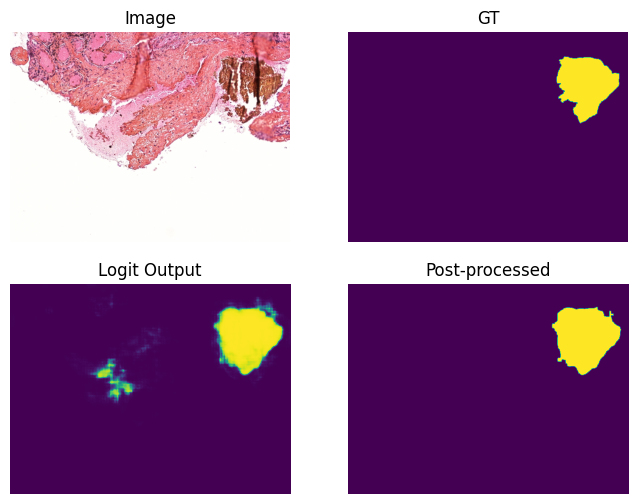

In [101]:
# Check a few

test_path = val_paths[67]

image, gt = return_image_and_mask(DATA_DIR, test_path)

rel_path = test_path.split('/', 1)[1] # remove first directory
logit_mask_path = os.path.join('multitask_validation', rel_path)
postproc_mask_path = os.path.join('multitask_postproc_validation', rel_path)

logit_pred = return_mask(DATA_DIR, logit_mask_path)
postproc_pred = return_mask(DATA_DIR, postproc_mask_path)

# Plot prediction before and after processing
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax[0][0].imshow(image)
ax[0][0].set_title('Image')
ax[0][0].axis('off')

ax[0][1].imshow(gt)
ax[0][1].set_title('GT')
ax[0][1].axis('off')

ax[1][0].imshow(logit_pred)
ax[1][0].set_title('Logit Output')
ax[1][0].axis('off')

ax[1][1].imshow(postproc_pred)
ax[1][1].set_title('Post-processed')
ax[1][1].axis('off')

plt.show()